# Simulate molecular production and degradation with Gillespie simulations

In this tutorial, we simulate the birth-death process to describe molecular production and degradation, and test the goodness of Quasi Steady State Approximation (QSSA) for mRNA dynamics.

First, we import  a couple of libraries for computation and plotting. More information on these libraries can be found in the respective documentation pages for [Numpy](https://numpy.org) and [Matplotlib](https://matplotlib.org).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Also, a neat trick to display the figure inside the notebook:

In [2]:
%matplotlib inline

## Part 1 - Simulate the full model (transcription + translation)

First, we simulate the full process of molecule synthesis including transcription of mRNA and translation into protein. This model includes 4 possible reactions:
1) Production of a new mRNA molecule with constant rate $k_{m}$

2) Degradation of an mRNA molecule with rate $\gamma_{m}\ m$

3) Production of a protein molecule with rate $k_{p}\ m$

4) Degradation of a protein molecule with rate $\gamma_{p}\ p$

First, we define a function that takes as argument the model's parameters ($k_{m}$, $\gamma_{m}$, $k_{p}$, $\gamma_{p}$) and copy numbers of mRNA and protein ($m$, $p$) and computes the rates of the 4 possible reactions:

In [3]:
def compute_rates(km, gm, kp, gp, m0, p0):
    rates = np.array([ km, gm*m0, kp*m0, gp*p0 ])
    return rates

Next, we define a function that takes the list of rates computed with the function *compute_rates* as input and randomly selects a reaction with probability based on the individual reaction rates: 

In [4]:
def select_reaction(rate_list):
    # this function takes as input the list of 4 rates (rate_list) 
    # and returns an integer index i=0,1,2, or 3 representing the index of the reaction that occurred

    # normalize the rates, so each rate can be interpreted as the probability of the reaction to occur
    total_rate = np.sum(rate_list)
    prob = rate_list / total_rate

    # draw a random number in [0, 1]
    rnd = np.random.uniform(low=0, high=1)
    # select the reaction beased on the value of the random number
    i = 0
    while np.sum(prob[0:i + 1]) < rnd:
        i = i + 1

    return i

Finally, we define a function that executes the reaction selected with *select_reaction*:

In [5]:
def execute_reaction(m_old, p_old, i):
    # i=0 is mRNA production, m is increased by a unit
    if i==0:
        m_new, p_new = m_old+1, p_old
    # i=1 is mRNA degradation, m is decreased by a unit
    elif i==1:
        m_new, p_new = m_old-1, p_old
    # i=2 is pritein production, p is increased by a unit
    elif i==2:
        m_new, p_new = m_old, p_old+1
    # i=3 is protein degradation, p is decreased by a unit
    else:
        m_new, p_new = m_old, p_old-1
    return m_new, p_new

We are now ready to write a simulation function to perform the Gillespie simulation. This function takes the following inputs:

1) The initial condition for copy numbers of mRNA and protein (m, p);

2) The number of events, or individual instances of reactions, that we want to simulate (n_event);

3) The model's parameters ($k_{m}$, $\gamma_{m}$, $k_{p}$, $\gamma_{p}$).

and returns the n_event-long vectors of copy numbers for mRNA and protein after each simulation step.  

In [6]:
def sim(m0, p0, n_event, km, gm, kp, gp):
    m_vec, p_vec = np.zeros(n_event), np.zeros(n_event)

    for i in range(n_event):
        rates = compute_rates(km, gm, kp, gp, m0, p0)
        reac = select_reaction(rates)
        m_new, p_new = execute_reaction(m0, p0, reac)
        m_vec[i], p_vec[i] = m_new, p_new
        m0, p0 = m_new, p_new
    return m_vec, p_vec

To actually simulate the process, we pick values for the model parameters, and fix a random generator seed for reproducibility of the results.

In [7]:
# RNG seed
np.random.seed(100)

# model's parameters
km, kp = 1, 1
gm, gp = 0.1, 0.1

# initial condition and number of events
m0, p0 = 10, 100
n_event = 100000

To run the simulationm, we simply call *sim*:

In [8]:
m_vec, p_vec = sim(m0, p0, n_event, km, gm, kp, gp)

Now, we plot the distribution of protein copy number. To facilitate visualization, we also define a function to compute the Gaussian distribution of the data:

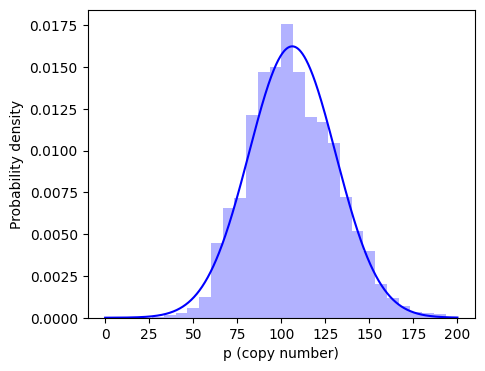

In [9]:
def gauss(x, m, s):
    S = np.sqrt( 2*np.pi*s*s )
    return np.exp(-((x-m)**2)/(2*s*s))/S

fig = plt.figure(figsize=(5,4))

ax = plt.subplot(111)
dist, bins = np.histogram(p_vec, bins=np.linspace(0, 200, 31))
dx = bins[1]-bins[0]
dist = dist/(np.sum(dist)*dx)
x = bins[0:-1] + dx/2.
plt.bar(x, dist, color='b', width=dx, alpha=0.3, label='Full model\n(Transcription +\nTranslation)');
plt.xlabel('p (copy number)');
plt.ylabel('Probability density')

mean, std = np.mean(p_vec), np.std(p_vec)
x = np.linspace(0, 200, 1000)
plt.plot( x, gauss(x, mean, std), 'b-' );

The simulation result shows that the pritein copy number fluctuates very close tho the theoretical value $p_{eq}=\frac{k_m\ k_p}{\gamma_{m}\ \gamma_{p}}$, and a standard deviation that is a function of the model's parameters, as we will explore in more detail in the next section.

In [10]:
mean, std

(106.22442, 24.576187980718245)

## Part 2 - Testing the QSSA for mRNA dynamics

Now, we want to test the goodness of the QSSA approximation for mRNA dynamics, where we assume that mRNA copy number instantly equilibrates to its average level $m_{eq}=\frac{k_m}{\gamma_m}$. The result is a simpler model where the protein is produced with at fixed rate $k_p$ and degraded at rate $\gamma_p\ p$. 

We introduce similar functions to compute the rates and execute the reactions (note that the function to choose the reaction is general enough and does not need a new version), as well as simulate the process: 

In [11]:
def compute_rates_QSSA(kp, gp, m0, p0):
    rates = np.array([ kp*m0, gp*p0 ])
    return rates

def reaction_QSSA(p_old, i):
    if i==0:
        return p_old+1
    else:
        return p_old-1
    
def sim_QSSA(p0, n_event, kp, gp):
    p_vec = np.zeros(n_event)

    for i in range(n_event):
        rates = compute_rates_QSSA(kp, gp, m0, p0)
        reac = select_reaction(rates)
        p = reaction_QSSA(p0, reac)
        p_vec[i] = p
        p0 = p
    return p_vec

We use the same parameters and initial conditions set for the full simulation. Note that by choosing the same values for $k_p$ and $\gamma_p$, we guarantee the same average value of protein copy number.

In [13]:
p_QSSA = sim_QSSA(p0, n_event, kp, gp)

Now, we can compare the protein copy numebr distribution between the full model and QSSA model. From this comparison, it is evident that assuming instant equilibration of mRNA implies a narrower protein copy number distribution, thus underestimating the fluctuations of the full model.

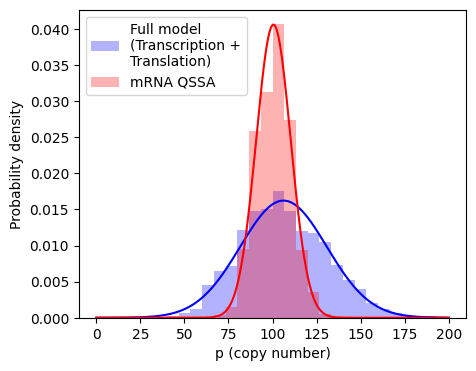

In [14]:
fig = plt.figure(figsize=(5,4))

ax = plt.subplot(111)

# distribution of full model data
dist, bins = np.histogram(p_vec, bins=np.linspace(0, 200, 31))
dx = bins[1]-bins[0]
dist = dist/(np.sum(dist)*dx)
x = bins[0:-1] + dx/2.
plt.bar(x, dist, color='b', width=dx, alpha=0.3, label='Full model\n(Transcription +\nTranslation)')

# distribution of QSSA model data
dist, bins = np.histogram(p_QSSA, bins=np.linspace(0, 200, 31))
dx = bins[1]-bins[0]
dist = dist/(np.sum(dist)*dx)
x = bins[0:-1] + dx/2.
plt.bar(x, dist, color='r', width=dx, alpha=0.3, label='mRNA QSSA')

# add the Gaussian fits
mean, std = np.mean(p_vec), np.std(p_vec)
x = np.linspace(0, 200, 1000)
plt.plot( x, gauss(x, mean, std), 'b-' )

mean, std = np.mean(p_QSSA), np.std(p_QSSA)
x = np.linspace(0, 200, 1000)
plt.plot( x, gauss(x, mean, std), 'r-' )

plt.xlabel('p (copy number)');
plt.ylabel('Probability density');
plt.legend(loc='upper left');

Finally, we can test how the goodness of QSSA improves as the timescales of mRNA and protein dynamics separate. In other words, if the reactions associated with mRNA bacome faster and faster compared to protein dynamics, the assumption that mRNA instantaneously equilibrates becomes better and better.

For example, by multiplying the mRNA transcription and degradation rate constants by a factor of 10, we do not change the average copy numbers of mRNA and protein, but make the mRNA dynamics 10-fold faster, thus resulting in a narrower protein copy number distribution that is similar to the QSSA distribution. 

In [17]:
m_vec_double, p_vec_double = sim(m0, p0, n_event, 10*km, 10*gm, kp, gp)

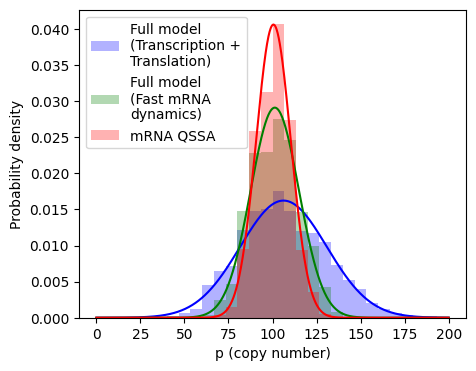

In [19]:
fig = plt.figure(figsize=(5,4))

ax = plt.subplot(111)

# distribution of full model data
dist, bins = np.histogram(p_vec, bins=np.linspace(0, 200, 31))
dx = bins[1]-bins[0]
dist = dist/(np.sum(dist)*dx)
x = bins[0:-1] + dx/2.
plt.bar(x, dist, color='b', width=dx, alpha=0.3, label='Full model\n(Transcription +\nTranslation)')

# distribution of full model data
dist, bins = np.histogram(p_vec_double, bins=np.linspace(0, 200, 31))
dx = bins[1]-bins[0]
dist = dist/(np.sum(dist)*dx)
x = bins[0:-1] + dx/2.
plt.bar(x, dist, color='g', width=dx, alpha=0.3, label='Full model\n(Fast mRNA\ndynamics)')

# distribution of QSSA model data
dist, bins = np.histogram(p_QSSA, bins=np.linspace(0, 200, 31))
dx = bins[1]-bins[0]
dist = dist/(np.sum(dist)*dx)
x = bins[0:-1] + dx/2.
plt.bar(x, dist, color='r', width=dx, alpha=0.3, label='mRNA QSSA')

# add the Gaussian fits
mean, std = np.mean(p_vec), np.std(p_vec)
x = np.linspace(0, 200, 1000)
plt.plot( x, gauss(x, mean, std), 'b-' )

mean, std = np.mean(p_vec_double), np.std(p_vec_double)
x = np.linspace(0, 200, 1000)
plt.plot( x, gauss(x, mean, std), 'g-' )

mean, std = np.mean(p_QSSA), np.std(p_QSSA)
x = np.linspace(0, 200, 1000)
plt.plot( x, gauss(x, mean, std), 'r-' )

plt.xlabel('p (copy number)');
plt.ylabel('Probability density');
plt.legend(loc='upper left');

We encourage to further explore these topics in our review and contact us for any comment or question at fbocci@uci.edu.